**Objectif**
L'objectif principal ici est de vérifier la présence de multicolinéarité dans nos données.

**Démarche**
- Etude de la coorélation bivariée entre variables
- Cette coorélation bivariée enrichit l'interprétation dans la multicolinéarité avec ACP

**Résultats**

- L'analyse démontre une forte multicolinéarité entre les variables explicatives. La multicolinéarité peut linéaire ou non. 
- La multicolinéarité découverte ici caractérise le cycle économique par l'évolution ensemble de la production industrielle, le revenu des ménages et leur consommation contre l'indicateur de la récession et l'évolution du chômage. Dans la sphère monétaire, la politique monétaire expansive engendre une inflation.

**Discussion**
- La solution est donc soit on supprime les variables qui apportent les mêmes informations, soit on régularise ; 
- La suppression de variables appauvrit le pouvoir explicatif de nos modèles. Voilà pourquoi, on effectue idéalement la régularisation RIDGE dans le prochain fichier ;
- Il y aura quand une chance que le modèle VAR/VECM améliore les résultats puisque la multicolinéarité linéaire n'est aussi fort. 
- Commençons aussi avec un modèle de Machine Learning capable de traiter la non linéarité.

# Package

In [28]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Importation des données

In [20]:
df_stationary_train = pd.read_csv("df_stationary_normalized_train.csv", index_col='date')
df_stationary_train.head()

,UNRATE,TB3MS,RPI,INDPRO,DPCERA3M086SBEA,S&P 500,BUSLOANS,CPIAUCSL,OILPRICEx,M2SL,USREC
date,,,,,,,,,,,
1960-01-01,-0.707603,0.258000,1.600570,2.124429,-0.869827,0.040084,0.702241,-1.065643,-0.192303,0.159013,-0.464344
1960-02-01,-0.975091,-0.213742,0.721466,2.124429,-0.349741,-0.604513,0.721912,-0.653288,-0.192303,0.251119,-0.464344
1960-03-01,-0.172628,-1.166854,-0.418607,-0.021802,1.299011,-1.273115,-0.497139,-0.944635,-0.192303,0.159099,-0.464344
1960-04-01,0.005696,-1.109089,-0.385880,-1.870811,2.541907,-0.823148,-0.541840,0.875096,-0.192303,0.066267,2.147592
1960-05-01,0.005696,-0.675857,-0.213422,-1.445408,-0.021650,-0.374132,-0.015981,0.580544,-0.192303,0.516318,2.147592


In [8]:
X = df_stationary_train.drop("UNRATE", axis = 1)

# 1-Etude de la coorélation bivariée entre variables

C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


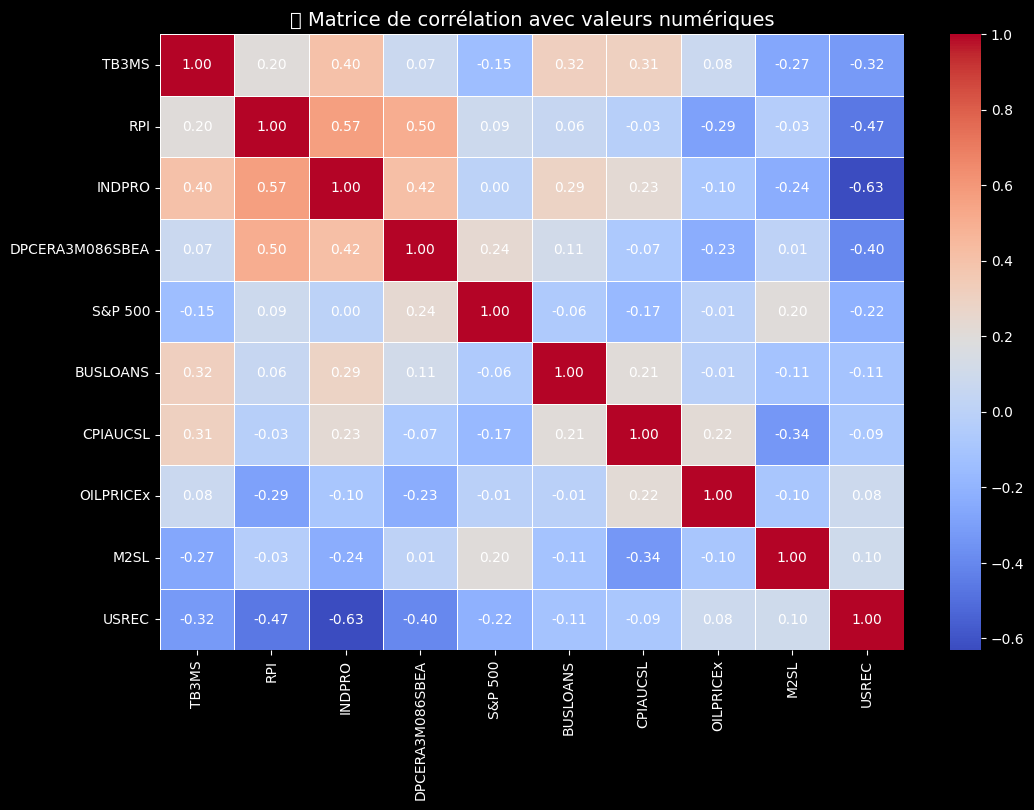

In [ ]:
# Style sombre (fond noir global)
plt.style.use("dark_background")

plt.figure(figsize=(12, 8))

# Heatmap
sns.heatmap(
    X.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.7,
    cbar=True,
    annot_kws={"color": "white"}  # chiffres lisibles sur fond sombre
)

# Titre
plt.title("📌 Matrice de corrélation avec valeurs numériques", fontsize=14, color="white")

# Axe en blanc
plt.xticks(color="white")
plt.yticks(color="white")

plt.show()

In [16]:
# Test de significativité de coorélation
results = []
for var1, var2 in itertools.combinations(X.columns, 2):
    r, p = pearsonr(X[var1], X[var2])
    results.append({
        "Variable_1": var1,
        "Variable_2": var2,
        "Correlation": r,
        "p_value": p,
        "Significatif_5pct": "Oui" if p < 0.05 else "Non"
    })

df_corr_sig = pd.DataFrame(results).sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [18]:
df_corr_sig.head()

,Variable_1,Variable_2,Correlation,p_value,Significatif_5pct
0,RPI,INDPRO,0.571942,1.164236e-32,Oui
1,RPI,DPCERA3M086SBEA,0.503985,1.376993e-24,Oui
2,INDPRO,DPCERA3M086SBEA,0.417863,1.202791e-16,Oui
3,TB3MS,INDPRO,0.401200,2.356429e-15,Oui
4,TB3MS,BUSLOANS,0.315146,9.643360e-10,Oui


In [19]:
df_corr_sig["Significatif_5pct"].value_counts()

Significatif_5pct
Oui    28
Non    17
Name: count, dtype: int64

Le test de significativité de coorélation entre variable explicative a fait montré que 28 variables sont coorélées linéairement entre eux. Pour plus de précision, nous allons donc effectuer maintenant une analyse ACP.

# 2- Etude de la multi-colinéarité avec ACP

## Standartisation des variables dans son ensemble

In [25]:
# Que des variables quantitatives
X = (
    df_stationary_train
    .drop(columns=["UNRATE"])
    .select_dtypes(include=[np.number])
    .dropna()
)

In [26]:
# --- 2) Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Lancement de l'ACP

In [29]:
# On installe l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [30]:
# Pourcentage de variance expliquée par axe
print("Variance expliquée (%) :", pca.explained_variance_ratio_ * 100)

# Valeurs propres
print("Valeurs propres :", pca.explained_variance_)

Variance expliquée (%) : [28.80696615 19.4428433  10.55886479  9.20132333  7.30857894  6.31776613
  6.14561879  5.14732943  4.31548878  2.75522036]
Valeurs propres : [2.88872084 1.94970016 1.05882767 0.92269538 0.73289371 0.63353644
 0.61627375 0.51616674 0.43275096 0.27628951]


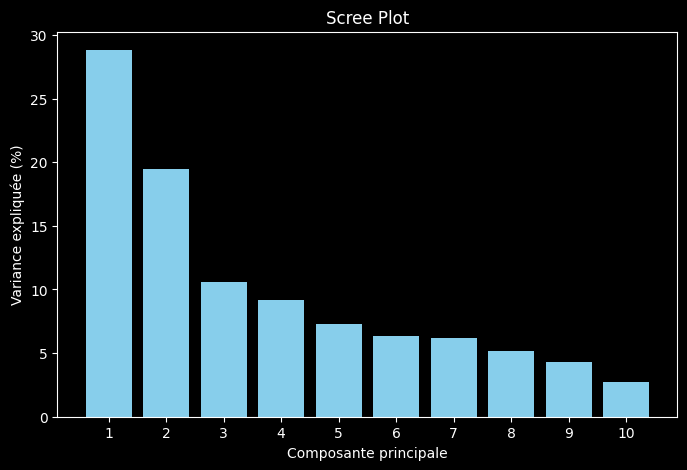

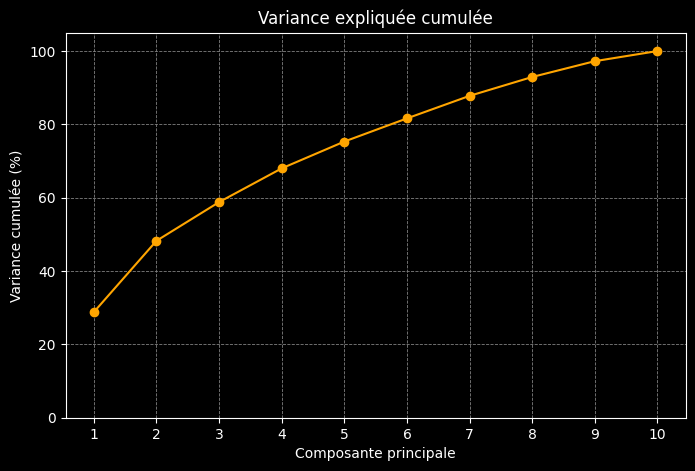

In [32]:
# Image des valeurs propres
evr = pca.explained_variance_ratio_ * 100  # en %

# --- Thème DARK ---
plt.style.use("dark_background")

# --- Scree Plot ---
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(evr)+1), evr, color="skyblue")
plt.xlabel("Composante principale", color="white")
plt.ylabel("Variance expliquée (%)", color="white")
plt.title("Scree Plot", color="white")
plt.xticks(range(1, len(evr)+1), color="white")
plt.yticks(color="white")
plt.show()

# --- Variance cumulée ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(evr)+1), np.cumsum(evr), marker="o", color="orange")
plt.xlabel("Composante principale", color="white")
plt.ylabel("Variance cumulée (%)", color="white")
plt.title("Variance expliquée cumulée", color="white")
plt.xticks(range(1, len(evr)+1), color="white")
plt.yticks(color="white")
plt.ylim(0, 105)
plt.grid(color="gray", linestyle="--", linewidth=0.6)  # grille lisible sur fond noir
plt.show()

L'ACP ne capte pas rapidement les informations. En effet, Les deux premiers axes expliquent à eux seuls environ 48% de l’inertie totale. Avec trois axes, on approche 60%. Or, d'habitude, trois axes nous permettent d'aller chercher plus de 80% des informations. 

Encore une fois, c'est le signe d'une relation non linéaire dans les variables explicatives. Puisque l'ACP se repose sur des hypothèses de linéarité. 

Essayons d'avoir les informations avec les deux premiers axes s'ils permettent d'avoir des informations sur le cycle économique.

## ACP sur les 02 premiers axes

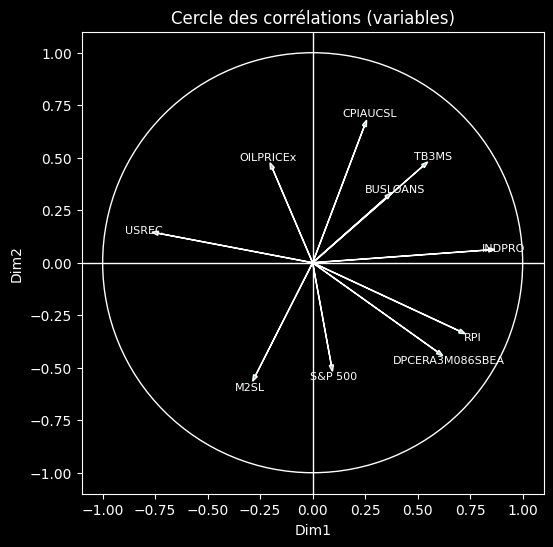

In [33]:
# Cercle des corrélations (variables)
# Pour données standardisées, corr(var, axe) = composantes * sqrt(valeurs_propres)
features = getattr(X, "columns", [f"V{i+1}" for i in range(pca.components_.shape[1])])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)   # (p x k)
corr = loadings[:, :2]

plt.figure(figsize=(6,6))
circle = plt.Circle((0, 0), 1, fill=False, linewidth=1)
plt.gca().add_artist(circle)
for i in range(corr.shape[0]):
    plt.arrow(0, 0, corr[i, 0], corr[i, 1], head_width=0.02, length_includes_head=True)
    plt.text(corr[i, 0]*1.05, corr[i, 1]*1.05, str(features[i]), ha='center', va='center', fontsize=8)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Dim1"); plt.ylabel("Dim2")
plt.title("Cercle des corrélations (variables)")
plt.show()

**Règle d'interprétations**
- Les flèches proches du cercle → variables bien représentées (corrélation forte avec les axes).
- Les flèches proches du centre → variables faiblement corrélées avec les deux axes (peu expliquées).
- Les flèches proches de l’un des axes → variable corrélée fortement avec cet axe spécifique.
- Les flèches proches entre elles → variables positivement corrélées.
- Les flèches opposées → corrélation négative.
- Les flèches orthogonales → indépendance.
- On ajoute les résultats de corrélation vue d'en haut pour améliorer les interprétations.

**La multicolinéarité : cycle économique et sphère monétaire**

La dimension horizontale (Dimension 2) caractérise le cycle économique, et donc la sphère réelle de l’économie. Une relation négative saute immédiatement aux yeux : USREC et INDPRO. Cela signifie que si la production industrielle augmente, l’économie n’est pas en récession, et inversement. La corrélation entre ces deux variables est la plus forte, à -0,63. De plus, une production élevée contribue à accroître les revenus (RPI, corrélation de 0,57). Une hausse du revenu influence positivement et logiquement la consommation (DPCERA3M086SBEA, corrélation de 0,50).

L’axe factoriel 1, quant à lui, illustre partiellement le comportement de la sphère monétaire. Une augmentation de l’offre de monnaie (M2SL) tend à accroître l’inflation mesurée par l’indice des prix à la consommation (CPIAUCSL, corrélation de -0,34), conformément à la théorie quantitative de la monnaie de Milton Friedman.

On observe ainsi que la sphère monétaire présente une certaine indépendance par rapport au cycle économique. L’offre monétaire et l’indice des prix à la consommation sont pratiquement orthogonaux aux variables liées au cycle économique.

En poussant l’analyse, des relations peuvent toutefois exister entre ces deux sphères. Par exemple, le crédit bancaire (BUSLOANS) est proche de la production industrielle (INDPRO), ce qui suggère un lien potentiel, bien qu’il ne soit pas pleinement démontré par les deux premiers axes factoriels.

Chercher d’autres relations au-delà de ces deux axes n’est pas nécessairement révélateur. Environ 50 % des informations principales, captées par les deux premiers axes, suffisent à mettre en évidence la multicolinéarité des variables liées au cycle économique. De plus, ces axes offrent des informations pertinentes sur la sphère monétaire américaine.

L’hypothèse vérifiée ici est qu’une multicolinéarité existe bel et bien entre les variables explicatives.

Nous ajoutons à présent la variable supplémentaire — la cible UNRATE — qui, sans caractériser les axes, enrichit l’interprétation.

# On va ajouter UNRATE comme variable supplémentaire dans l'ACP

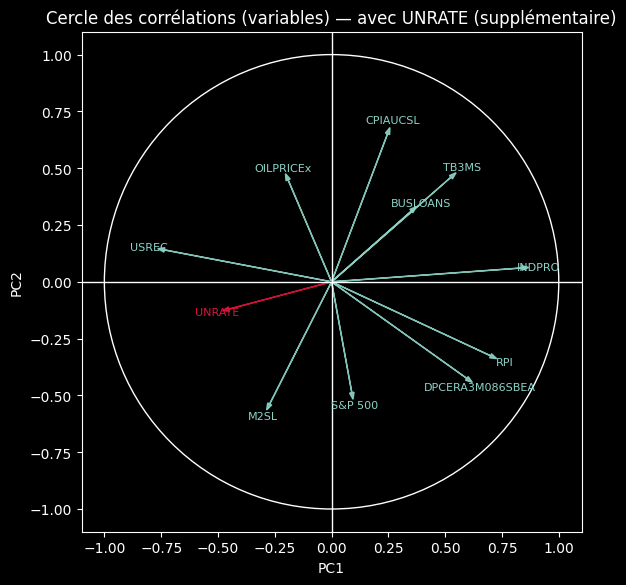

In [34]:
# --- (on suppose que X = df_stationary_train sans 'UNRATE', déjà nettoyé comme pour ta PCA) ---
# Si tu n'as pas encore les 'scores' (coordonnées individus), on les (re)calcule :
from sklearn.preprocessing import StandardScaler
try:
    X_scaled  # existe déjà ?
except NameError:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

scores = pca.transform(X_scaled)  # (n_obs x n_PC)

# --- 1) Corrélations variables-axes (déjà dans ton code) ---
# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)   # (p x k)
# corr = loadings[:, :2]  # coordonnées des variables sur (PC1, PC2)

# --- 2) Ajouter UNRATE comme variable SUPPLÉMENTAIRE ---
# On aligne UNRATE sur les mêmes lignes que X (et on retire les NaN éventuels côté UNRATE)
y_all = df_stationary_train.loc[X.index, "UNRATE"].astype(float)
mask  = y_all.notna()
y     = y_all[mask].values
scores_aligned = scores[mask.values, :]  # mêmes lignes

# Corrélation de UNRATE avec chaque axe (ici PC1, PC2)
r_unrate_pc1 = np.corrcoef(y, scores_aligned[:, 0])[0, 1]
r_unrate_pc2 = np.corrcoef(y, scores_aligned[:, 1])[0, 1]
unrate_coords = np.array([r_unrate_pc1, r_unrate_pc2])

# On étend les tableaux pour le tracé
features_ext = list(features) + ["UNRATE"]
corr_ext = np.vstack([corr, unrate_coords])

# --- 3) Tracé du cercle + UNRATE en couleur distincte ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.add_artist(plt.Circle((0,0), 1, fill=False, linewidth=1))

for i in range(corr_ext.shape[0]):
    is_unrate = (features_ext[i] == "UNRATE")
    color = "crimson" if is_unrate else "C0"
    ax.arrow(0, 0, corr_ext[i, 0], corr_ext[i, 1],
             head_width=0.02, length_includes_head=True, color=color, alpha=0.9)
    ax.text(corr_ext[i, 0]*1.05, corr_ext[i, 1]*1.05, str(features_ext[i]),
            ha='center', va='center', fontsize=8, color=color)

ax.axhline(0, linewidth=1); ax.axvline(0, linewidth=1)
ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("Cercle des corrélations (variables) — avec UNRATE (supplémentaire)")
plt.tight_layout()
plt.show()

D'après ce qu'on voit, la corrélation linéaire avec le taux de chômage n'est pas élevée. Par contre, son ajout en tant que variable supplémentaire permet de comprendre qu'elle varit inversement au cycle économique des Etats-Unis.